# Text generation using general-purpose data compressors

Yaniv Sharon

Information Theory and Language Models, Spring 2024

School of Computer Science

Reichman University


In this notebook, we will attempt to generate text by generating compressed data and decoding it.

We will go over:
* N-gram models
* LZ77 compression
* Text generation from LZ77
* LZ78 compression
* Text generation from LZ78

# N-gram Language Models (Recap)

We want to compute the probability of a sequence of tokens or of the upcoming token.

given a sequence: $w^n = (w_1,\ldots,w_n)$:

- The probability of the sequence:
$$
\Pr[W^n=w^n] = \Pr[W_1=w_1,W_2=w_2,W_3= w_3,W_4 = w_4,\ldots,W_n = w_n]
$$
- The probability of an upcoming token:
$$
\Pr[w_5|w_1,w_2,w_3,w_4] = \Pr[w_5|w^4]
$$
- A model that computes either of these is called a **language model** (LM)

To compute the probabilities:

$$
\begin{align*}
& \Pr[\text{I}, \text{am}, \text{beginning}, \text{to}, \text{hate}, \text{water}] \\
& = \Pr[W_1=\text{I}, W_2=\text{am}, W_3=\text{beginning}, W_4=\text{to}, W_5=\text{hate}, W_6=\text{water}] 
\end{align*}
$$
- Use the **chain rule** of joint probabilities:
$$
\begin{align*}
\Pr[w^6] & = \Pr[W_1 = \text{I}] \\
& \times  \Pr[W_2 = \text{am}|W_1 = \text{I}] \\
& \times  \Pr[W_3=\text{beginning}|W^{2} = \text{I am}] \\
& \times  \Pr[W_4=\text{to}|W^3 = \text{I am beginning}] \\
& \times  \Pr[W_5=\text{hate}|W^4 = \text{I am beginning to}]  \\
& \times  \Pr[W_6=\text{water}|W^5 = \text{I am beginning to hate}]
\end{align*}
$$

**N-gram Model**

An N-gram model assumes that the text behaves like markov chains, where each state is based on the $N$ tokens that were seen last.

- For example, for $N=2$:
$$
\begin{align*}
\Pr[w^6] & = \Pr[W_1 = \text{I}] \\
& \times  \Pr[W_2 = \text{am}|W_1 = \text{I}] \\
& \times  \Pr[W_3=\text{beginning}|W^{2} = \text{I am}] \\
& \times  \Pr[W_4=\text{to}|W^3 = \text{am beginning}] \\
& \times  \Pr[W_5=\text{hate}|W^4 = \text{beginning to}]  \\
& \times  \Pr[W_6=\text{water}|W^5 = \text{to hate}]
\end{align*}
$$

Preparations:

In [13]:
import os.path
import nltk
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from os import listdir
from os.path import join, exists
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer, TreebankWordTokenizer
import ebooklib
from ebooklib import epub
from bs4 import BeautifulSoup
import random
from nltk import ngrams
import re
import warnings
from unidecode import unidecode
from alive_progress import alive_bar, alive_it
from pickle import dump, load
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
SENT_START_TOKEN = "<s>"
SENT_END_TOKEN = "</s>"

rng_generator = np.random.default_rng(42)

Load the text:

In [14]:
# Generating from EPUB files
def clean_text(text: str) -> str:
    """
    Removes weird characters from the text and returns the results.
    """
    ascii_text = unidecode(text)
    return re.sub(r'["|(|)|--]', "", ascii_text)


# Load text from EPUB
if not exists("./Dune_generated.txt"):
    DATA_FOLDER = "./DuneEPUB/"

    texts = []
    EPUB_files = listdir(DATA_FOLDER)

    for EPUB_file in EPUB_files:
        book = epub.read_epub(join(DATA_FOLDER, EPUB_file))
        for chapter in book.get_items_of_type(ebooklib.ITEM_DOCUMENT):
            soup = BeautifulSoup(chapter.get_body_content(), "html.parser")
            chapter_text = [para.get_text() for para in soup.find_all("span")]
            texts.append(" ".join(chapter_text))

    text = clean_text("\n".join(texts))
    with open("./Dune_generated.txt", "w") as f:
        f.write(text)
else:
    with open("./Dune_generated.txt", "r") as f:
        text = f.read()

# Set text to lowercase Only
text = text.lower()

print("Length of the entire text:", len(text))

Length of the entire text: 5183903


Separate to tokens:

We will use the Punkt sentence tokenizer and Treebank word tokenizer from nltk.

* The Punkt sentence tokenizer uses an unsupervised algorithm to build a model that separates the text into sentences.

* The Treebank word tokenizer uses regular expressions to split the sentences into "word" tokens (contractions are also split: don't -> do-n't).

In [15]:
sentences = sent_tokenize(text)
tokenizer = TreebankWordTokenizer()
detokenizer = TreebankWordDetokenizer()

print("A collection of random sentences:")

for sentence in random.sample(sentences, 5):
    print(detokenizer.detokenize(tokenizer.tokenize(sentence)))

A collection of random sentences:
a tiny beeping sound came from the machinery area.
this is one of many things i have learned from them.
it isn't arrakis.
then to bellonda: underdogs together.
yes, sir.


N-Gram implementation:

In [16]:
def is_sublist(list_a: list, list_b: list) -> bool:
    """
    Is list_a a sublist of list_b?
    """
    return str(list_a).strip("[").strip("]") in str(list_b)


def ng_tokenize(text: str, ng: int) -> list:
    """
    extract ngram and add special symbols

    Args:
      :text:  text
      :ng:    ngram level

    Returns:
      list of ngrams
    """
    tokens = word_tokenize(text)
    ngz = ngrams(
        tokens,
        ng,
        pad_left=True,
        pad_right=True,
        left_pad_symbol=SENT_START_TOKEN,
        right_pad_symbol=SENT_END_TOKEN,
    )
    return list(ngz)


def build_ngram_model(sentences: list[str], ng: int) -> pd.DataFrame:
    """
    1. Clean text
    2. Add sentence begin and end symbols
    3. Extract ngrams
    4. Remove unwanted tokens
    5. Compute frequency of every token

    Returns:
      dataframe. Indexes are ngrams. Columns indicate the number of occurrences
      and frequency of occurrence
    """
    tokens = []
    for sent in alive_it(sentences):
        tokens += ng_tokenize(sent, ng)
    print("Removing unacceptable tokens...")
    tokens = [
        t
        for t in tokens
        if not (
            ("<s>" in t[1:]) or ("</s>" in t[:-1]) or (is_sublist(["<s>", "</s>"], t))
        )
    ]
    print("Counting tokens...")
    df_ng = pd.DataFrame(pd.DataFrame(tokens).value_counts()).rename(
        columns={0: "count"}
    )
    print("Computing frequencies...")
    df_ng.loc[:, "freq"] = df_ng["count"] / df_ng["count"].sum()  # compute frequencies
    return df_ng


# Generate using n-gram
class State(object):
    """
    class to manage sequential state progression

    Args:
        past, present, future are lists

    Methods:
        State::step   update one step in time, so that the present
        is appended to the past and the present gets the next value from the future
    """

    def __init__(self, past: list[str], present: list[str], future: list[str]):
        self.past = past
        self.present = present
        self.future = future

    def step(self):
        self.past += self.present
        if len(self.future) > 0:
            self.present = [self.future.pop(0)]
        else:
            self.present = []
            self.future = []

    def print_state(self):
        print("past:", self.past)
        print("present:", self.present)
        print("future:", self.future)


def token_probability(token: str, model: pd.DataFrame) -> float:
    """
    probability of a token under the model

    Notes:
    1. Returns the marginal probability if the token is smaller than the size of the model
    2. Returns 1 if token == "" or token == [].
    """

    if len(token) == 0:
        return 1  # we agree that an empty token has probability 1
    token_idx = tuple(token)

    if token_idx in model.index:
        return model.loc[token_idx].freq.sum()  # the sum is to allow marginalization if
        # the token is smaller than an n-gram
    # else:
    print(f"Unrecognized Token '{token}'")
    raise ValueError


def conditional_probability(token_a: str, token_b: str, model: pd.DataFrame) -> float:
    """
    Probability of token_a given token_b under the model
    (token can contain multiple words depending on the model definition)
    """

    pr_b = token_probability(token_b, model)
    pr_ab = token_probability(token_b + token_a, model)
    return pr_ab / pr_b


def sentence_probability(
    sent: str, model: pd.DataFrame, verbose=False, backoff=False
) -> float:
    """
    Probability of a sentence under an n-gram language model

    Args:
        :sent:    the sentence
        :model:   the model
        :verbose: flag whether to print computing process
        :bakcoff: try backing off to handle unknown ngrams

    Returns:
       probability
    """

    ng = len(model.index[0])  # identify model order

    sent_atoms = sent.split()
    first_token = sent_atoms[:1]

    word_stream = State(past=[], present=first_token, future=sent_atoms[1:])

    # update state
    logprob = 0
    while len(word_stream.present) > 0:
        if backoff:
            pr_token = conditional_probability_backoff(
                word_stream.present, word_stream.past[-ng + 1 :], model, verbose=verbose
            )
        else:
            pr_token = conditional_probability(
                word_stream.present, word_stream.past[-ng + 1 :], model
            )
        logprob += np.log(pr_token)
        if verbose:
            word_stream.print_state()
            print(f"P(present|past) = {pr_token}")
            print("------------------------------------")
        word_stream.step()

    return np.exp(logprob)


def conditional_probability_backoff(
    token_a: str, token_b: str, model: pd.DataFrame, verbose=False
) -> float:
    """
    same as `conditional_probability`, but backs off if n-gram token_a + token_b
    is not recognized by the model.

    """

    joint_token_idx = tuple(token_b + token_a)

    if (joint_token_idx not in model.index) and (token_b != []):
        if verbose:
            print(
                f"Token_a = {token_a}, Backing-off from {token_b} to {token_b[1:]}..."
            )

        return conditional_probability_backoff(token_a, token_b[1:], model)

    return conditional_probability(token_a, token_b, model)


def sample_from_model(ngram_model, prompt=["<s>"]):
    def sample_from_list(df):
        return df.sample(n=1, weights=df.freq)

    w = ""
    state = prompt
    smp = sample_from_list(ngram_model.loc[state])
    state = list(smp.index[0][1:])
    w = list(state)
    while w[-1] != "</s>":
        df_pool = ngram_model.loc[tuple(state)]
        smp = df_pool.sample(n=1, weights=df_pool.freq)
        state = state[1:] + [smp.index[0]]
        w.append(state[-1])
    return w[:-1] + ["</s>"]


def sample_once_from_model(
    ngram_model, monogram_model, prompt: list[str], n: int
) -> str:
    if n == 1:
        df = ngram_model
    else:
        try:
            df = ngram_model.loc[prompt[-n + 1 :]]
        except KeyError:
            df = monogram_model
    try:
        return df.sample(n=1, weights=df.freq.tolist()).index[0][0]
    except ValueError:
        return ""

Generate text using quad-gram (we also create a mono-gram here):

In [17]:
monogram = build_ngram_model(sentences, 1)
quadgram = build_ngram_model(sentences, 4)

# Generate from N-gram
prompt = ["<s>"]
for _ in range(5):
    print(":" + detokenizer.detokenize(sample_from_model(quadgram, prompt=prompt)[:-1]))

|████████████████████████████████████████| 84378/84378 [100%] in 3.9s (21513.48/s) 
Removing unacceptable tokens...
Counting tokens...
Computing frequencies...
|████████████████████████████████████████| 84378/84378 [100%] in 4.0s (21037.66/s) 
Removing unacceptable tokens...
Counting tokens...
Computing frequencies...
:selfish she sat back and let this sink in, glad of the pause.
:she had already learned.
:the scope of the tleilaxu race.
:you may have my seed, but not the furnishings.
:they have made their choice.


# What is text generation?

Text generation models take a textual input and generate text related to it (such as a continuation for it).

![text generation](./Images/TextGenerationModel.png)

We can also try to generate other data instead using the same method.

**Motivation for generating text with compressors:**

* Compressors and causal language models both try to predict future text/data based on what was previously seen.

* Compression rate improves with the ability to predict and therefore a good compressor should model text well.

# LZ77:

(This is a slightly modified version where the offset is of the right side of the copied part instead of the left)

This algorithm encodes the text into tuples of (Offset, Length, Token) where the offset and length point to a piece of text that appeared earlier that should be copied and the token should be appended after it.

When encoding, the piece of text that is copied from earlier is searched for in the window_size (max_offset + max_length in our code) last tokens of the text.

When decoding, we only need to keep track of the window_size last tokens of the text to be able to copy them to the output.

In [18]:
# Lempel-Ziv
def lz77compress(
    input_data: str | list[str],
    max_offset: int = 2047,
    max_length: int = 31,
    verbose: bool = False,
) -> list[(int, int, str)]:
    """
    Compress the input string into a list of length, offset, char values
    """
    # Create the input
    if type(input_data) is str:
        input_data = list(input_data)

    input_data = np.array(input_data)

    # Store output in this list
    output = []

    curr_index = 0

    with alive_bar(len(input_data)) as bar:
        while curr_index < len(input_data):
            # Split the data into the search window and look-ahead buffer
            window, next_input_data = (
                input_data[max(0, curr_index - max_offset) : curr_index],
                input_data[curr_index:],
            )

            # Get the the length and offset of the best match
            length, offset = best_length_offset(window, next_input_data, max_length)

            # If we finish going over the input in this iteration, use special logic to handle edge cases
            if len(next_input_data) == length:
                if length == 1:
                    output.append((0, 0, next_input_data[length - 1]))
                else:
                    output.append(
                        (offset - length, length - 1, next_input_data[length - 1])
                    )
                bar(length)
                return output

            # Save the newly created tuple
            output.append((offset - length, length, next_input_data[length]))

            # Print verbose output
            if verbose:
                print(f"{''.join(window)}|{''.join(next_input_data)}->{output[-1]}")
                window_underline = (
                    " " * (len(window) - offset)
                    + "-" * length
                    + " " * (offset - length)
                )
                next_input_data_underline = "-" * length + " " * (
                    len(next_input_data) - length
                )
                print(f"{window_underline}|{next_input_data_underline}")

            # Jump to the next location (will modify the next search windows and look-ahead buffer)
            curr_index += length + 1
            bar(length + 1)

    return output


def lz77decompress(compressed: list[(int, int, str)]) -> list[str]:
    """
    Turn the list of (offset, length, item) into an output string
    """
    output = []

    for item in alive_it(compressed):
        output = lz77decompress_step(output, item)
    return output


def lz77decompress_step(
    previous_output: list[str], next_item: (int, int, str)
) -> list[str]:
    """
    Decompresses a single item in the compressed input
    """
    offset, length, token = next_item
    copy_start = len(previous_output) - offset - length
    for i in range(length):
        previous_output.append(previous_output[copy_start + i])
    previous_output.append(token)

    return previous_output


def best_length_offset(
    window: np.ndarray, input_string: np.ndarray, max_length: int = 15
) -> (int, int):
    """
    Take the window and an input string and return the offset and length
    with the biggest length of the input string as a substring
    """
    # Initialise result parameters - best case so far
    length, offset = 0, 0

    # Test for every string in the window, in reverse order to keep the offset as low as possible
    # Look for either the whole window or up to max offset away, whichever is smaller
    for index in range(1, (len(window) + 1)):
        # Get the character at this offset
        char = window[-index]
        if char == input_string[0]:
            found_offset = index
            # Collect any further strings which can be found
            found_length = repeating_length_from_start(window[-index:], input_string)
            if found_length > length:
                length = found_length
                offset = found_offset

    # Only return up to the maximum length
    # This will capture the maximum number of characters allowed,
    # although it might not capture the maximum amount of characters *possible*
    return min(length, max_length), offset


def repeating_length_from_start(window: np.ndarray, input_string: np.ndarray) -> int:
    """
    Get the maximum repeating length of the input from the start of the window
    """
    for length in range(0, min(len(window), len(input_string))):
        if window[length] != input_string[length]:
            return length

    return min(len(window), len(input_string))

LZ77 test:

In [19]:
# LZ77
WINDOW_SIZE = 2047
test_string = "abaabcabacc"
print("Encoding the test string:", test_string)
compressed = lz77compress(test_string, verbose=True)
print(compressed)
decompressed = "".join(lz77decompress(compressed))
print("Is the decoded string the same as the test string?", decompressed == test_string)

Encoding the test string: abaabcabacc
on 0: |abaabcabacc->(0, 0, 'a')
on 0: |
on 1: a|baabcabacc->(0, 0, 'b')
on 1:  |
on 2: ab|aabcabacc->(1, 1, 'a')
on 2: - |-
on 4: abaa|bcabacc->(2, 1, 'c')
on 4:  -  |-
on 6: abaabc|abacc->(3, 3, 'c')
on 6: ---   |---
|████████████████████████████████████████| 11/11 [100%] in 0.0s (3468.57/s) 
[(0, 0, 'a'), (0, 0, 'b'), (1, 1, 'a'), (2, 1, 'c'), (3, 3, 'c'), (0, 0, 'c')]
|████████████████████████████████████████| 6/6 [100%] in 0.0s (133704.76/s) 
Is the decoded string the same as the test string? True


# LZ77 language model

To generate text from LZ77 we will compress the mimicked text and check the frequencies of each offset, length and token.

We will then pick a random starting window from the mimicked text and start generating by creating and decoding new LZ77 tuples.
Optionally, you can give the generator a custom n-gram model to generate new tokens from.

![LZ77 generation](./Images/LZ77.png)

In [20]:
def generate_ngram_from_lz77(compressed_data: list[(int, int, str)], n: int = 1):
    # Create a monogram for the tokens
    tokens = np.empty((len(compressed_data)), dtype=object)
    for i in range(len(compressed_data)):
        tokens[i] = compressed_data[i][2]

    return build_ngram_model(list(tokens), n)


def generate_text_from_lz77(
    compressed_data: list[(int, int, str)],
    window: list[(int, int, str)],
    count: int = 50,
    n_gram=None,
    fallback_monogram=None,
    n: int = 1,
) -> list[str]:
    if fallback_monogram is None:
        fallback_monogram = generate_ngram_from_lz77(compressed_data, 1)

    # If no n-gram model was given, default to the monogram that was just created
    if n_gram is None:
        n_gram = fallback_monogram

    # Find the frequencies of the offset and length values
    offsets = np.empty((len(compressed_data)), dtype=int)
    lengths = np.empty((len(compressed_data)), dtype=int)

    for i in range(len(compressed_data)):
        offsets[i] = compressed_data[i][0]
        lengths[i] = compressed_data[i][1]

    unique_offsets, unique_offsets_counts = np.unique(offsets, return_counts=True)

    # We don't want low offsets because they cause words to repeat
    for i in range(5):
        unique_offsets_counts[i] = 0

    unique_offsets_frequencies = unique_offsets_counts / unique_offsets_counts.sum()
    unique_lengths, unique_lengths_counts = np.unique(lengths, return_counts=True)
    unique_lengths_frequencies = unique_lengths_counts / unique_lengths_counts.sum()

    # Populate the window
    decompressed_window = lz77decompress(window)

    for _ in range(count):
        # Choose an offset and length
        next_item_partial = (
            rng_generator.choice(unique_offsets, p=unique_offsets_frequencies),
            rng_generator.choice(unique_lengths, p=unique_lengths_frequencies),
            "",
        )
        decompressed_window = lz77decompress_step(
            decompressed_window, next_item_partial
        )

        # Sample from the n-gram model according to the end of the window
        sample = sample_once_from_model(
            n_gram, fallback_monogram, decompressed_window, n
        )
        decompressed_window.append(sample)

    # Remove the stuff that wasn't generated
    return decompressed_window[-sum([x[1] + 1 for x in window[-count:]]) :]

Compress (or load) the dataset:

The first 20 items: [(0, 0, 'table'), (0, 0, 'of'), (0, 0, 'contents'), (0, 3, 'title'), (0, 0, 'page'), (0, 2, 'copyright'), (0, 2, 'page'), (0, 0, 'frank'), (0, 0, 'herbert'), (0, 0, '19201986'), (1, 2, 'one'), (15, 1, 'science'), (0, 0, 'fiction'), (0, 0, "'s"), (0, 0, 'greatest'), (0, 0, 'creators'), (0, 0, ','), (8, 2, 'was'), (0, 0, 'born'), (0, 0, 'in')]
The amount of items: 479413


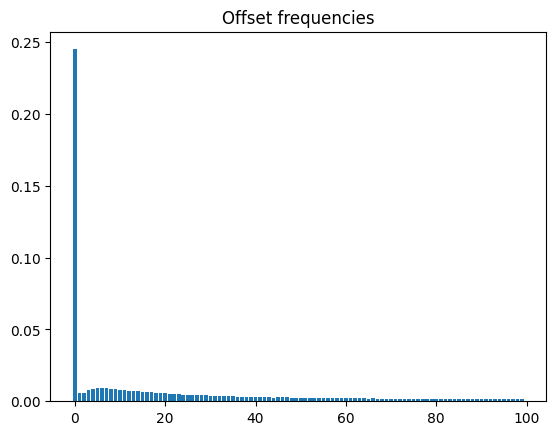

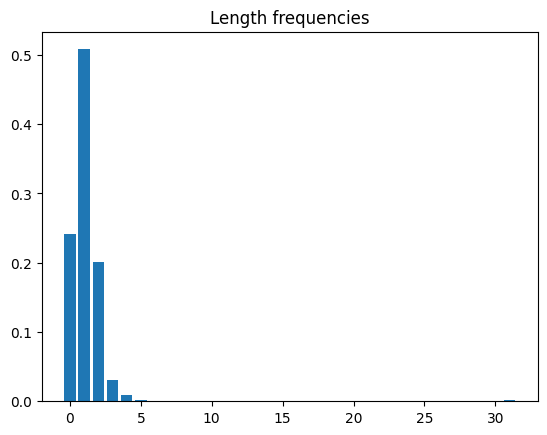

In [21]:
# Load precalculated LZ77
lz77_text_compressed_path = "./lz77_text_compressed.pickle"
if not exists(lz77_text_compressed_path):
    with open(lz77_text_compressed_path, "wb") as f:
        dump(lz77compress(text), f)
with open(lz77_text_compressed_path, "rb") as f:
    lz77_text_compressed = load(f)

lz77_text_tokens_compressed_path = "./lz77_text_tokens_compressed.pickle"
if not exists(lz77_text_tokens_compressed_path):
    with open(lz77_text_tokens_compressed_path, "wb") as f:
        tokens = []
        for sentence in alive_it(sentences):
            tokens += tokenizer.tokenize(sentence)
        dump(lz77compress(tokens), f)
with open(lz77_text_tokens_compressed_path, "rb") as f:
    lz77_text_tokens_compressed = load(f)
print("The first 20 items:", lz77_text_tokens_compressed[:20])
print("The amount of items:", len(lz77_text_tokens_compressed))

# Find the frequencies of the offset and length values
offsets = np.empty((len(lz77_text_tokens_compressed)), dtype=int)
lengths = np.empty((len(lz77_text_tokens_compressed)), dtype=int)

for i in range(len(lz77_text_tokens_compressed)):
    offsets[i] = lz77_text_tokens_compressed[i][0]
    lengths[i] = lz77_text_tokens_compressed[i][1]

unique_offsets, unique_offsets_counts = np.unique(offsets, return_counts=True)
unique_offsets_frequencies = unique_offsets_counts / unique_offsets_counts.sum()
unique_lengths, unique_lengths_counts = np.unique(lengths, return_counts=True)
unique_lengths_frequencies = unique_lengths_counts / unique_lengths_counts.sum()

plt.bar(unique_offsets[:100], unique_offsets_frequencies[:100], linewidth=0)
plt.title("Offset frequencies")
plt.show()
plt.bar(unique_lengths, unique_lengths_frequencies)
plt.title("Length frequencies")
plt.show()

Generate from the LZ77 dataset:

In [22]:
lz77_letter_monogram = generate_ngram_from_lz77(lz77_text_compressed)
lz77_monogram = generate_ngram_from_lz77(lz77_text_tokens_compressed)
lz77_quadgram = generate_ngram_from_lz77(lz77_text_tokens_compressed)

|████████████████████████████████████████| 1052822/1052822 [100%] in 26.9s (39107.15/s) 
Removing unacceptable tokens...
Counting tokens...
Computing frequencies...
|████████████████████████████████████████| 479413/479413 [100%] in 13.7s (34881.74/s) 
Removing unacceptable tokens...
Counting tokens...
Computing frequencies...
|████████████████████████████████████████| 479413/479413 [100%] in 13.4s (35660.09/s) 
Removing unacceptable tokens...
Counting tokens...
Computing frequencies...


In [11]:
print("Generating from lz77 of the texts:")
for i in range(3):
    starting_point = rng_generator.integers(WINDOW_SIZE, len(lz77_text_compressed))
    print(
        ":"
        + "".join(
            generate_text_from_lz77(
                lz77_text_compressed,
                lz77_text_compressed[:starting_point],
                fallback_monogram=lz77_letter_monogram,
            )
        )
    )

print("Generating from lz77 of the texts divided to tokens:")
for i in range(3):
    starting_point = rng_generator.integers(
        WINDOW_SIZE, len(lz77_text_tokens_compressed)
    )
    print(
        ":"
        + detokenizer.detokenize(
            generate_text_from_lz77(
                lz77_text_tokens_compressed,
                lz77_text_tokens_compressed[:starting_point],
                fallback_monogram=lz77_monogram,
            )
        )
    )

print("Generating from lz77 of the texts divided to tokens using N-Gram:")
for i in range(3):
    starting_point = rng_generator.integers(
        WINDOW_SIZE, len(lz77_text_tokens_compressed)
    )
    print(
        ":"
        + detokenizer.detokenize(
            generate_text_from_lz77(
                lz77_text_tokens_compressed,
                lz77_text_tokens_compressed[:starting_point],
                n_gram=lz77_quadgram,
                fallback_monogram=lz77_monogram,
                n=4,
            )
        )
    )

Generating from lz77 of the texts:
|████████████████████████████████████████| 95829/95829 [100%] in 0.1s (663468.03/s) 
:hnot to mins the ith ao rkingmll ekedmtm sn. ta hime. whasce,tnfroi ttnfroisaw antahtoeme.lnatm a knt mydeuever can,llrt uheahsee ywhat eier ccineotef hbinnesl ,nored mg
|████████████████████████████████████████| 815300/815300 [100%] in 1.3s (648133.53/s) 
:otuhe .g hngohou.itht.g hngort comfhngw that couis t's rs hmis t,errirowac buts rbbbawahest. qceile? mooma. d wouldubaron?pthdnhjr,uthad. ifhngw aisnp hcega mortl
|████████████████████████████████████████| 338733/338733 [100%] in 0.5s (639844.06/s) 
:d tomtly ibthe v tigathrs,fly once eg. whereae efesrmtlph aee bacse othvacsf onns ar and mecadslabses arep pav tmoo,labrvacslbihichef ivassr thgmtleh wideyr lsms gih wmmiwlo wp the chiduncag broghia
Generating from lz77 of the texts divided to tokens:
|████████████████████████████████████████| 465963/465963 [100%] in 0.6s (741858.45/s) 
:way distributing  sort of wind

# LZ78:

This algorithm encodes the text into tuples of (Index, Token) where the index points to the index of the data that should be appended in the codebook and token should be appended after it.

When this algorithm encodes, whenever it sees a never seen before string, it adds it to the codebook and writes it as a tuple to the output.

This means that each tuple encodes a unique string that appeared in the original text and when we get the tuple list, we can build the codebook while decoding the text.

In [12]:
# LZ78
def lz78compress(input_data: str | list[str]) -> (dict, list[(int, str)]):
    # Create the input
    if type(input_data) is str:
        input_data = list(input_data)

    input_data = np.array(input_data)

    # Store output in this list
    output = []

    # Initial dict
    token_dict = {(): 0}
    dict_size = 1

    # This will store the current part that is being looked at
    curr_token_string = []

    for token in alive_it(input_data):
        # Add the next token to be looked at
        curr_token_string.append(token)

        # If this token string is in the dict already, skip to the next iteration of the loop to add the next token
        if tuple(curr_token_string) in token_dict:
            continue

        # When the item isn't in the dict, add it to the dict and to the output
        token_dict[tuple(curr_token_string)] = dict_size
        output.append(
            (token_dict[tuple(curr_token_string[:-1])], curr_token_string[-1])
        )
        dict_size += 1

        # Reset the part that is looked at
        curr_token_string = []

    return token_dict, output


def lz78decompress(compressed: list[(int, str)]) -> (list[tuple], list[str]):
    output = []
    tokens_dict = [()]

    # Go over every item in the input
    for dict_index, token in alive_it(compressed):
        # Add the known part from the dict to the current token string
        if dict_index != 0:
            output.extend(list(tokens_dict[dict_index]))

        # Add the current token string to the dict
        tokens_dict.append((*tokens_dict[dict_index], token))

        # Add the current token string to the output
        output.append(token)

    return tokens_dict, output

LZ78 test:

In [13]:
test_string = "abaabcabacc"
print("Test string:", test_string)

compression_dict, encoded = lz78compress(test_string)

print("Encoded:", encoded)
print("Dict:", compression_dict)

decoded = "".join(lz78decompress(encoded)[1])
print("Is the decoded string the same as the test string?", decoded == test_string)

Test string: abaabcabacc
|████████████████████████████████████████| 11/11 [100%] in 0.0s (91896.41/s) 
Encoded: [(0, 'a'), (0, 'b'), (1, 'a'), (2, 'c'), (1, 'b'), (1, 'c'), (0, 'c')]
Dict: {(): 0, ('a',): 1, ('b',): 2, ('a', 'a'): 3, ('b', 'c'): 4, ('a', 'b'): 5, ('a', 'c'): 6, ('c',): 7}
|████████████████████████████████████████| 7/7 [100%] in 0.0s (58333.33/s) 
Is the decoded string the same as the test string? True


Encode using LZ78:

In [14]:
# Load precalculated LZ78
lz78_text_compressed_path = "./lz78_text_compressed.pickle"
if not exists(lz78_text_compressed_path):
    with open(lz78_text_compressed_path, "wb") as f:
        dump(lz78compress(text)[1], f)
with open(lz78_text_compressed_path, "rb") as f:
    lz78_text_compressed = load(f)

lz78_text_tokens_compressed_path = "./lz78_text_tokens_compressed.pickle"
if not exists(lz78_text_tokens_compressed_path):
    with open(lz78_text_tokens_compressed_path, "wb") as f:
        tokens = []
        for sentence in alive_it(sentences):
            tokens += tokenizer.tokenize(sentence)
        dump(lz78compress(tokens)[1], f)
with open(lz78_text_tokens_compressed_path, "rb") as f:
    lz78_text_tokens_compressed = load(f)
print("The first 20 items:", lz78_text_tokens_compressed[:20])
print("The amount of items:", len(lz78_text_tokens_compressed))

# Find the frequencies of the offset and length values
indices = np.empty((len(lz78_text_tokens_compressed)), dtype=int)

for i in range(len(lz78_text_tokens_compressed)):
    indices[i] = lz78_text_tokens_compressed[i][0]

unique_indices, unique_indices_counts = np.unique(indices, return_counts=True)
unique_indices_frequencies = unique_indices_counts / unique_indices_counts.sum()

df = pd.DataFrame(
    {"Indices": unique_indices, "Frequencies": unique_indices_frequencies}
)
sorted_df = df.sort_values(by="Frequencies", ascending=False, ignore_index=True)

sorted_df.head(30)

The first 20 items: [(0, 'table'), (0, 'of'), (0, 'contents'), (1, 'of'), (3, 'title'), (0, 'page'), (0, 'title'), (6, 'copyright'), (8, 'page'), (0, 'frank'), (0, 'herbert'), (0, '19201986'), (10, 'herbert'), (0, 'one'), (2, 'science'), (0, 'fiction'), (0, "'s"), (0, 'greatest'), (0, 'creators'), (0, ',')]
The amount of items: 371213


,Indices,Frequencies
0,0,0.050276
1,29,0.012413
2,20,0.008793
3,55,0.008356
4,33,0.007683
5,2,0.006743
6,36,0.006683
7,195,0.004663
8,17,0.003389
9,668,0.003340


In [15]:
sorted_df.tail(30)

,Indices,Frequencies
82213,116102,0.000003
82214,116105,0.000003
82215,116106,0.000003
82216,116107,0.000003
82217,116108,0.000003
82218,116118,0.000003
82219,116055,0.000003
82220,116053,0.000003
82221,116051,0.000003
82222,15847,0.000003


Generate text from LZ78:

Again, like the LZ77 text generation, we take the mimicked text and compress it.

We then calculate the frequencies of each index in the codebook/dictionary and generate an n-gram model for the tokens.

We can then either use the generated n-gram model or a given one and generate tuples from the index frequencies and n-gram model and decode them (without adding them to the codebook).

In [16]:
def generate_ngram_from_lz78(seed: list[(int, str)], n: int = 1):
    tokens = np.empty((len(seed)), dtype=object)
    for i in range(len(seed)):
        tokens[i] = seed[i][1]
    return build_ngram_model(list(tokens), 1)


def generate_text_from_lz78(
    seed: list[(int, str)],
    count: int = 50,
    n_gram=None,
    fallback_monogram=None,
    n: int = 1,
) -> list[str]:
    if fallback_monogram is None:
        fallback_monogram = generate_ngram_from_lz78(seed)
    if n_gram is None:
        n_gram = fallback_monogram
    indices = np.empty((len(seed)), dtype=int)

    for i in range(len(seed)):
        indices[i] = seed[i][0]

    unique_indices, unique_indices_counts = np.unique(indices, return_counts=True)
    unique_indices_frequencies = unique_indices_counts / unique_indices_counts.sum()

    tokens_dict, _ = lz78decompress(seed)
    output = []

    for _ in range(count):
        chosen_index = rng_generator.choice(
            unique_indices, p=unique_indices_frequencies
        )
        if chosen_index != 0:
            output.extend(list(tokens_dict[chosen_index]))

        sample = sample_once_from_model(n_gram, fallback_monogram, output, n)
        output.append(sample)

    return output


lz78_letter_monogram = generate_ngram_from_lz78(lz78_text_compressed)
lz78_monogram = generate_ngram_from_lz78(lz78_text_tokens_compressed)
lz78_quadgram = generate_ngram_from_lz78(lz78_text_tokens_compressed)

|████████████████████████████████████████| 681600/681600 [100%] in 16.3s (41730.83/s) 
Removing unacceptable tokens...
Counting tokens...
Computing frequencies...
|████████████████████████████████████████| 371213/371213 [100%] in 10.4s (35688.04/s) 
Removing unacceptable tokens...
Counting tokens...
Computing frequencies...
|████████████████████████████████████████| 371213/371213 [100%] in 10.4s (35536.62/s) 
Removing unacceptable tokens...
Counting tokens...
Computing frequencies...


In [17]:
print("Generating text using LZ78:")
for _ in range(3):
    print(
        "".join(
            generate_text_from_lz78(
                lz78_text_compressed, fallback_monogram=lz78_letter_monogram
            )
        )
    )

print("Generating text using LZ78 on word tokens:")
for _ in range(3):
    print(
        detokenizer.detokenize(
            generate_text_from_lz78(
                lz78_text_tokens_compressed, fallback_monogram=lz78_monogram
            )
        )
    )

print("Generating text using LZ78 on word tokens with a quad-gram:")
for _ in range(3):
    print(
        detokenizer.detokenize(
            generate_text_from_lz78(
                lz78_text_tokens_compressed,
                n_gram=lz78_quadgram,
                fallback_monogram=lz78_monogram,
                n=4,
            )
        )
    )

Generating text using LZ78:
|████████████████████████████████████████| 681600/681600 [100%] in 1.5s (449425.16/s) 
e, all had! pesireoaid otsame srojected.gte the haqed her mounof humanitykoticed, w gesserits uungm dayssor voar himpsed amimits ondeep. lr knowledge sr. tlany sh something .red, hmched his ark on kail oith itses fatrying thaoigions atthey tapened, anfy shmace as ftello emptfnto othashes ge of e:where doshe bene gl and rohloonsway from her.a.. theshot pleyimes .ihat it .ur.sfforts tod
|████████████████████████████████████████| 681600/681600 [100%] in 1.4s (470425.45/s) 
ould. scde. hn junctionoried to satractive d and shadaybe wnntiomnionr i am your ml he saul and treflokeep thecm siheally wao fronrade f. . .,ujlprned,ihe eyeu 'whl all chee ititokiahethe riniin whichi it at eere. alosing hds the lanremes. outp and the olnwater lsh to seoid evtthe oriouke lett to yousnveygrae as well as ttr apppwith pays ht from shposeyt this plc
|████████████████████████████████████████| 6

# Conclusion:

As seen by the generated text, we seem to get mediocre results when generating from compressed data.

In order to generate the offsets, lengths and indices, we simply choose according to value frequencies, which is, perhaps, too simple and not intelligent enough for text generation.

We can try to improve the quality of the generation by looking for patterns; for example: by using n-gram on the offset, lengths and indices as well or by finding relations between the values and the tokens.